In [1]:
%reload_ext autoreload
%autoreload 2

import os
import gc
import sys
import logging
import multiprocessing
from pathlib import Path
from typing import Optional
from tqdm import tqdm

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
formatter = logging.Formatter(FORMAT)

fhandler = logging.FileHandler(filename='power-analysis.log', mode="w")
fhandler.setFormatter(formatter)
fhandler.setLevel(logging.INFO)
logger.addHandler(fhandler)

# consoleHandler = logging.StreamHandler(sys.stdout)
# consoleHandler.setFormatter(formatter)
# logger.addHandler(consoleHandler)


In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.priors = {"baseline", "delta", site.a, site.b, site.L, site.H, site.v, site.g_1, site.g_2}

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_baseline = numpyro.sample(
                    "mu_baseline",
                    dist.TruncatedNormal(5, 10, low=0)
                )
                sigma_baseline = numpyro.sample(
                    "sigma_baseline",
                    dist.HalfNormal(10.0)
                )

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    baseline = numpyro.sample(
                        "baseline",
                        dist.TruncatedNormal(mu_baseline, sigma_baseline, low=0)
                    )

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_delta = numpyro.sample("mu_delta", dist.Normal(0, 10))
                sigma_delta = numpyro.sample("sigma_delta", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    delta = numpyro.sample("delta", dist.Normal(mu_delta, sigma_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(10))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(2))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(10))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([baseline, baseline + delta], axis=1)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [3]:
import pickle


root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/human/intraoperative/config.toml")

CONFIG = Config(toml_path=toml_path)
MODEL = HierarchicalBayesianModel(config=CONFIG)

src = "/home/vishu/data/hbmep-processed/human/intraoperative/data.csv"
DF = pd.read_csv(src)

subset = [
    'scapptio001'
]
ind = ~DF[MODEL.subject].isin(subset)
DF = DF[ind].reset_index(drop=True).copy()

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)


2023-09-27 17:14:24,262 - hbmep.config - INFO - Verifying configuration ...
2023-09-27 17:14:24,262 - hbmep.config - INFO - Success!
2023-09-27 17:14:24,278 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-27 17:14:24,295 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/intraoperative
2023-09-27 17:14:24,295 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/intraoperative
2023-09-27 17:14:24,296 - hbmep.dataset.core - INFO - Processing data ...
2023-09-27 17:14:24,297 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [ ]:
df

In [4]:
TOTAL_SUBJECTS = 200

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 10], columns=[MODEL.intensity]),
        how="cross"
    )

PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num_points=20)
PREDICTION_DF.shape

2023-09-27 17:14:24,365 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


(8000, 3)

In [5]:
POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in MODEL.priors}
POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)

OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])
OBS.shape

2023-09-27 17:14:38,296 - hbmep.utils.utils - INFO - func:predict took: 13.89 sec


(4000, 8000, 1)

In [6]:
mu_delta_true = POSTERIOR_SAMPLES["mu_delta"]
mu_delta_true.shape

(4000, 1, 1)

In [7]:
prefix = "power-analysis"
N_space = [2, 4, 8, 12, 16, 20]

n_draws = 50
draws_space = \
    jax.random.choice(
        key=MODEL.rng_key,
        a=np.arange(0, mu_delta_true.shape[0], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 10
repeats_space = \
    jax.random.choice(
        key=MODEL.rng_key,
        a=np.arange(0, 100 * n_repeats, 1),
        shape=(n_repeats,),
        replace=False
    )

# """ Test """
# N_space = [2, 3, 4]

# n_draws = 4
# draws_space = \
#     jax.random.choice(
#         key=MODEL.rng_key,
#         a=np.arange(0, mu_delta_true.shape[0], 1),
#         shape=(n_draws,),
#         replace=False
#     ) \
#     .tolist()

# n_repeats = 2
# repeats_space = \
#     jax.random.choice(
#         key=MODEL.rng_key,
#         a=np.arange(0, 100 * n_repeats, 1),
#         shape=(n_repeats,),
#         replace=False
#     )



In [ ]:
logger.info(f"BUILD_DIR: {os.path.join(MODEL.build_dir, prefix)}")
logger.info(f"N_space: {', '.join(map(str, N_space))}")

logger.info(f"n_draws: {n_draws}")
logger.info(f"draws: {', '.join(map(str, draws_space))}")

logger.info(f"n_repeats: {n_repeats}")
logger.info(f"seeds: {', '.join(map(str, repeats_space))}")

mu_delta_predicted = None

for draw_counter, draw_ind in enumerate(draws_space):
    draw_dir = f"draw_{draw_ind}"
    curr_draw_mu_delta = None

    for N_counter, N in enumerate(N_space):
        N_dir = f"N_{N}"
        curr_N_mu_delta = None

        for repeat_counter, seed in enumerate(repeats_space):
            seed_dir = f"seed_{seed}"
            logger.info(f"\n\nDraw:{draw_counter + 1}/{n_draws}, N:{N_counter + 1}/{len(N_space)}, Repeat:{repeat_counter + 1}/{n_repeats}")

            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()
            logger.info(f"Seed:{seed}, Subjects: {', '.join(map(str, subjects_ind))}")

            ind = PREDICTION_DF[MODEL.subject].isin(subjects_ind)
            curr_df = PREDICTION_DF[ind].reset_index(drop=True).copy()

            df = curr_df.copy()
            df[MODEL.response] = OBS[draw_ind, ...][ind, ...]

            """ Build model """
            config = Config(toml_path=toml_path)
            config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, prefix, draw_dir, N_dir, seed_dir)
            model = HierarchicalBayesianModel(config=config)

            """ Load data """
            df, encoder_dict = model.load(df=df)

            """ Fit """
            logger.info("Fitting ...")
            mcmc, posterior_samples = model.run_inference(df=df)

            """ Predict """
            logger.info("Predicting ...")
            prediction_df = model.make_prediction_dataset(df=df, num_points=100)
            ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

            """ Plot """
            logger.info("Plotting recruitment curves ...")
            model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
            logger.info("Plotting posterior checks ...")
            model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

            """ Power """
            mu_delta = posterior_samples["mu_delta"]
            mu_delta = np.array(mu_delta[None, ...])

            """ Concatenate """
            if curr_N_mu_delta is None:
                curr_N_mu_delta = mu_delta
            else:
                curr_N_mu_delta = np.concatenate([curr_N_mu_delta, mu_delta], axis=0)

            config, curr_df, df, encoder_dict,  = None, None, None, None
            mcmc, model, posterior_samples = None, None, None
            prediction_df, ppd = None, None
            mu_delta = None

            del config, curr_df, df, encoder_dict, mcmc, model, posterior_samples, prediction_df, ppd, mu_delta
            gc.collect()

        """ Concatenate """
        curr_N_mu_delta = curr_N_mu_delta[None, ...]

        if curr_draw_mu_delta is None:
            curr_draw_mu_delta = curr_N_mu_delta
        else:
            curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, curr_N_mu_delta], axis=0)

    """ Concatenate """
    curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

    if mu_delta_predicted is None:
        mu_delta_predicted = curr_draw_mu_delta
    else:
        mu_delta_predicted = np.concatenate([mu_delta_predicted, curr_draw_mu_delta], axis=0)

    dst = os.path.join(MODEL.build_dir, prefix, f"mu_delta_predicted_Draw_{draw_counter + 1}.npy")
    np.save(dst, mu_delta_predicted)
    logger.info(f"Saved to {dst}")


In [27]:
from sys import getsizeof
getsizeof(mu_delta_predicted)

19200192

In [25]:
gc

<module 'gc' (built-in)>

In [16]:
mu_delta_predicted.shape

(10, 6, 10, 4000, 1, 1)

In [24]:
(mu_delta_predicted > 0).mean(axis=(-1, -2, -3))

array([[[0.90875, 0.93075],
        [0.9585 , 0.9145 ],
        [0.989  , 0.98525]],

       [[0.74775, 0.78825],
        [0.91425, 0.9245 ],
        [0.75575, 0.953  ]],

       [[0.789  , 0.724  ],
        [0.82375, 0.85025],
        [0.73375, 0.90625]],

       [[0.93575, 0.89575],
        [0.951  , 0.973  ],
        [0.98275, 0.8855 ]]])

In [25]:
((mu_delta_predicted > 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=(0, -1))

array([0.   , 0.375, 0.5  ])

In [11]:
((mu_delta_predicted > 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)

array([0.02, 0.48, 0.8 , 0.94, 1.  , 0.98])

In [14]:
N_space

[2, 4, 6, 8, 10, 12]

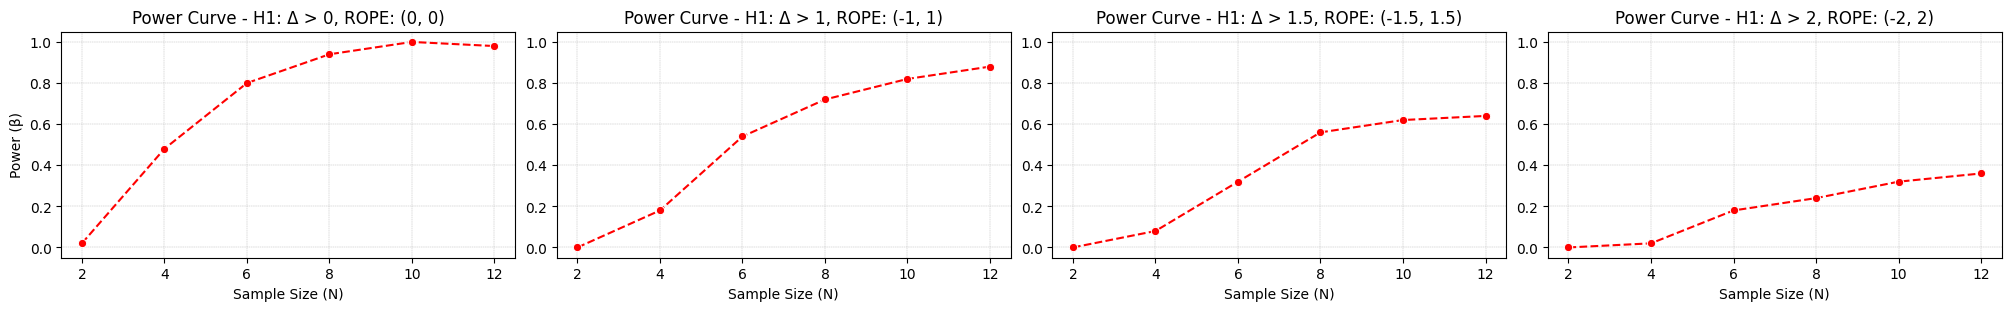

In [51]:
rope_space = [0, 1, 1.5, 2]

nrows, ncols = 1, len(rope_space)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True, sharey=True)

i = 0
for rope in rope_space:
    ax = axes[i // ncols, i % ncols]

    power = ((mu_delta_predicted > rope).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)

    sns.lineplot(x=N_space, y=power, marker="o", linestyle="--", color="r", ax=ax)

    ax.grid(linewidth=.3, linestyle="--", axis="both")
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_xticks(N_space)

    ax.set_title(f"Power Curve - H1: Δ > {rope}, ROPE: ({-1 * rope}, {rope})")
    ax.set_xlabel("Sample Size (N)")
    ax.set_ylabel("Power (β)")

    ax.yaxis.set_tick_params(labelleft=True)

    i += 1
